# English to French Neural Machine Translator

## Prepare the Data

In [1]:
# load the data
def load_data(filename):
    file = open(filename, mode='rt', encoding='utf-8')
    data = file.read()
    file.close()
    return data

In [2]:
# split data into pairs of english and french sentences
def line_split(data):
    lines = data.strip().split('\n')
    pairs = [line.split('\t') for line in lines]
    return pairs

In [3]:
# convert to list of phrases
def to_list(pairs):
    list_data = list()
    for pair in pairs:
        pair_data = list()
        for line in pair:
            # tokenize on white space
            line = line.split()
            pair_data.append(' '.join(line))
        list_data.append(pair_data)
    return array(list_data)

In [4]:
# execute the above functions
import numpy as np
import re
import string

from numpy import array
from pickle import dump
from unicodedata import normalize

# load the data
filepath = 'data/fra.txt'
data = load_data(filepath)

# split the data to pairs
pairs = line_split(data)

# convert to list
list_data = to_list(pairs)

In [5]:
for i in range(10):
    print(list_data[i])

print(list_data.shape)

['Go.' 'Va !']
['Hi.' 'Salut !']
['Run!' 'Cours !']
['Run!' 'Courez !']
['Who?' 'Qui ?']
['Wow!' 'Ça alors !']
['Fire!' 'Au feu !']
['Help!' "À l'aide !"]
['Jump.' 'Saute.']
['Stop!' 'Ça suffit !']
(167130, 2)


In [6]:
# save the list data to a file
def save_data(list_data, filename):
    dump(list_data, open(filename, 'wb'))
    
save_data(list_data, 'english_french.pkl')

## Splitting into Train and Test Set

In [7]:
from pickle import load

# load the list data
def load_list(filename):
    return load(open(filename, 'rb'))

loaded_data = load_list('english_french.pkl') 

In [8]:
# split into train and test set
from numpy.random import shuffle

n_samples = 10000 # no. of samples used
used_set = loaded_data[:n_samples, :]

shuffle(used_set)

train, test = used_set[:9000], used_set[9000:]

In [9]:
# save the loaded, train and test set to as .pkl files
save_data(used_set, 'used_data.pkl')
save_data(train, 'train_data.pkl')
save_data(test, 'test_data.pkl')

## The Neural Translation Model

In [10]:
# load the three data files
used_set = load_list('used_data.pkl')
train = load_list('train_data.pkl')
test = load_list('test_data.pkl')

In [11]:
# tokenize the data
def tokenize_data(data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data)
    return tokenizer

In [12]:
# maximum seuqence length
def max_len(data):
    return max(len(line.split()) for line in data)

### Tokenization and Creating Vocabulary

In [13]:
from keras.preprocessing.text import Tokenizer

# tokenize english sentences
english_tokenizer = tokenize_data(used_set[:, 0])
english_vocab_size = len(english_tokenizer.word_index) + 1
english_max_length = max_len(used_set[:, 0])

# tokenize french sentences
french_tokenizer = tokenize_data(used_set[:, 1])
french_vocab_size = len(french_tokenizer.word_index) + 1
french_max_length = max_len(used_set[:, 1])

print('English vocabulary size: ', english_vocab_size)
print('English max length: ', english_max_length)

print('French vocabulary size: ', french_vocab_size)
print('French max length: ', french_max_length)

Using TensorFlow backend.


English vocabulary size:  2141
English max length:  5
French vocabulary size:  4236
French max length:  10


### Encoding and Padding

In [14]:
# encode and pad the data
def encode_sequences(tokenizer, length, lines):
    X = tokenizer.texts_to_sequences(lines)
    X = pad_sequences(X, maxlen=length, padding='post')
    return X

In [15]:
# one hot encode the output sentences
def one_hot_output(sequences, vocab_size):
    target_list = list()
    for sequence in sequences:
        one_hot_encoded = to_categorical(sequence, 
                                         num_classes=vocab_size)
        target_list.append(one_hot_encoded)
    target = array(target_list)
    target = target.reshape(sequences.shape[0], sequences.shape[1],
                           vocab_size)
    return target

### Preparing Train and Test Data

In [16]:
# train data
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

X_train = encode_sequences(english_tokenizer, english_max_length, 
                          train[:, 0])
Y_train = encode_sequences(french_tokenizer, french_max_length, 
                          train[:, 1])
Y_train = one_hot_output(Y_train, french_vocab_size)
# validataion data
X_test = encode_sequences(english_tokenizer, english_max_length, 
                         test[:, 0])
Y_test = encode_sequences(french_tokenizer, french_max_length, 
                         test[:, 1])
Y_test = one_hot_output(Y_test, french_vocab_size)

### Defining the Model

In [17]:
# definition for Neural Translation Model
def define_model(source_vocab, target_vocab, source_timesteps, 
                 target_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(source_vocab, n_units, 
                        input_length=source_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(target_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(target_vocab, activation='softmax')))
    return model

In [19]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

# call `define_model()`
model = define_model(english_vocab_size, french_vocab_size, 
                     english_max_length, french_max_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5, 256)            548096    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 256)           525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 4236)          1088652   
Total params: 2,687,372
Trainable params: 2,687,372
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
# fit model
epochs = 30
batch_size = 64
filename = 'english_to_french.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, 
                            save_best_only=True, mode='min')
history = model.fit(X_train, Y_train, epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data=(X_test, Y_test), 
                    callbacks=[checkpoint], 
                    verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 9000 samples, validate on 1000 samples
Epoch 1/30
9000/9000 [==============================] - 23s 3ms/step - loss: 3.2204 - val_loss: 2.3551

Epoch 00001: val_loss improved from inf to 2.35514, saving model to english_to_french.h5
Epoch 2/30
9000/9000 [==============================] - 5s 606us/step - loss: 2.2538 - val_loss: 2.2420

Epoch 00002: val_loss improved from 2.35514 to 2.24198, saving model to english_to_french.h5
Epoch 3/30
9000/9000 [==============================] - 6s 615us/step - loss: 2.1429 - val_loss: 2.2123

Epoch 00003: val_loss improved from 2.24198 to 2.21234, saving model to english_to_french.h5
Epoch 4/30
9000/9000 [==============================] - 6s 619us/step - loss: 2.0766 - val_loss: 2.1628

Epoch 00004: val_loss improved from 2.21234 to 2.16281, saving model to english_to_french.h5
Epoch 5/30
9000/9000 [==============================] - 6s 622us/step - loss: 2.0106 - val_loss: 2.1115

Epoch 00005:

In [38]:
print(history.history.keys())

dict_keys(['val_loss', 'loss'])


### Plotting `val_loss` and `loss`

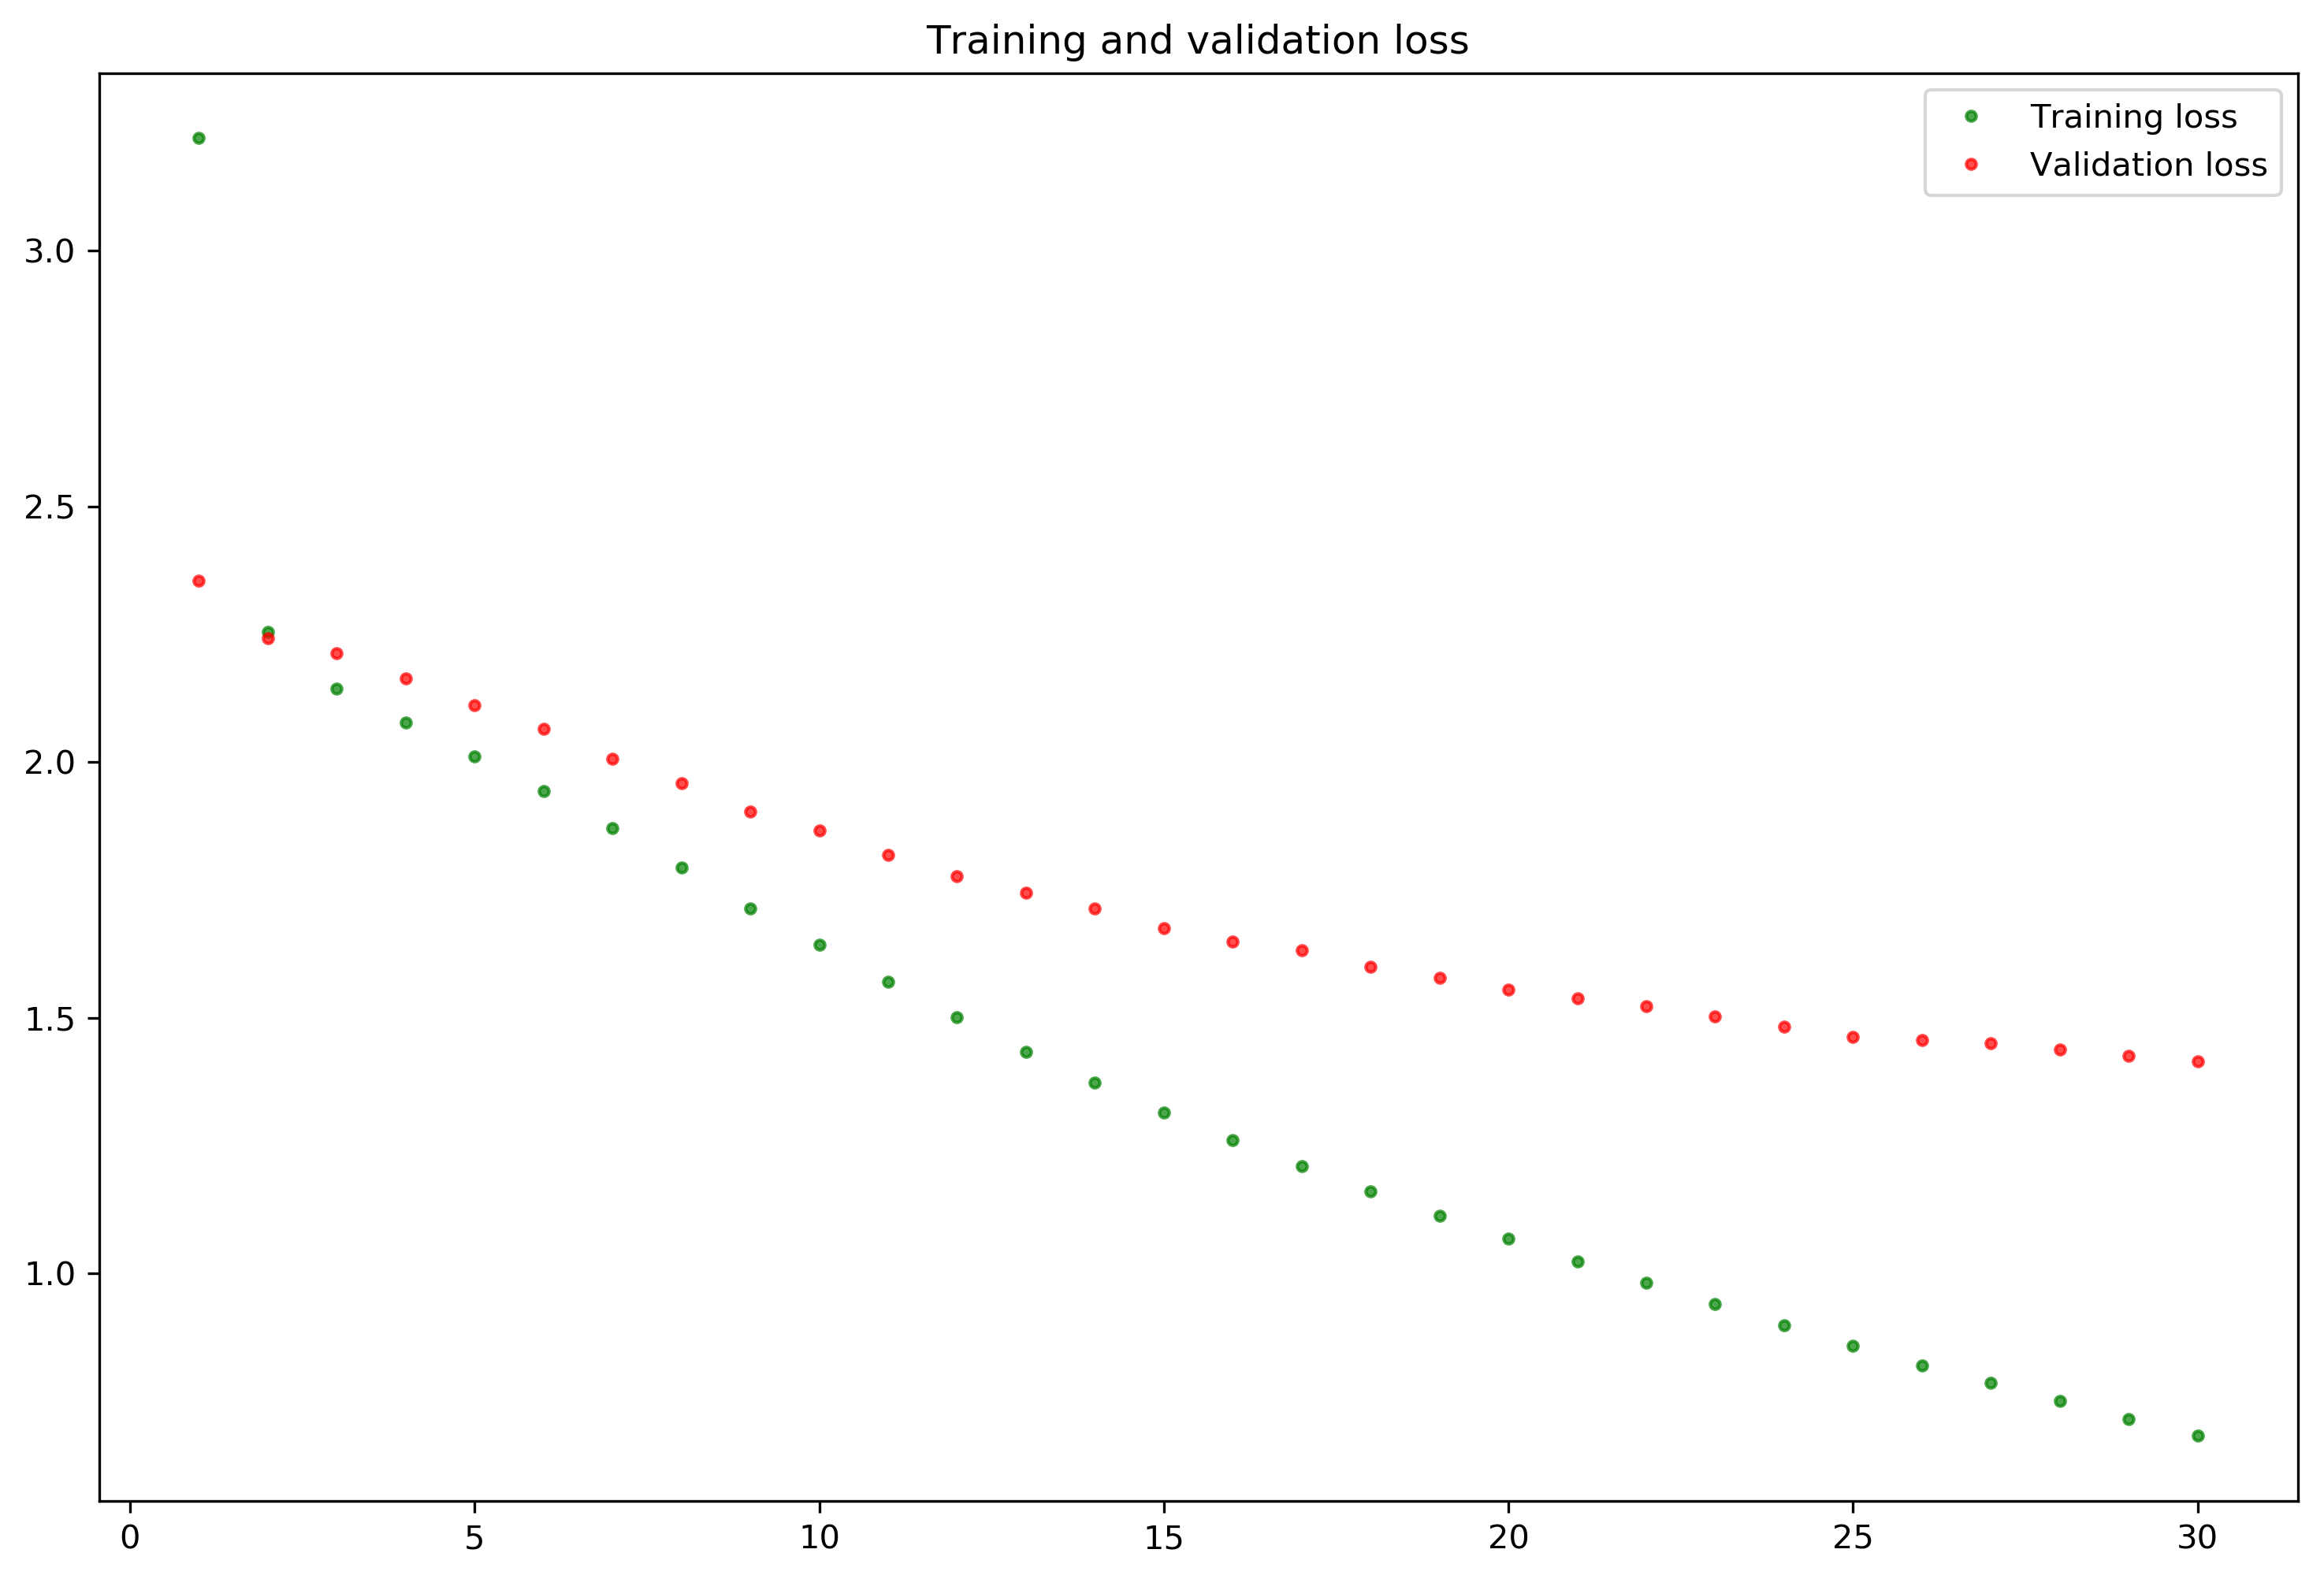

In [61]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 8), dpi=300)

plt.plot(epochs, loss, 'g.', label='Training loss', alpha=0.7)
plt.plot(epochs, val_loss, 'r.', label='Validation loss', alpha=0.7)
plt.title('Training and validation loss')
plt.legend()
plt.savefig('losses.png')

## Evaluating the Model

This code block can be used totally separately without running the previous steps each time.

In [1]:
from pickle import load
from numpy import array
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model

# load the list data
def load_list(filename):
    return load(open(filename, 'rb'))

# tokenize the data
def tokenize_data(data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data)
    return tokenizer

# maximum seuqence length
def max_len(data):
    return max(len(line.split()) for line in data)

# encode and pad the data
def encode_sequences(tokenizer, length, lines):
    X = tokenizer.texts_to_sequences(lines)
    X = pad_sequences(X, maxlen=length, padding='post')
    return X

# map id to word
def map_id(id, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == id:
            return word
    return None

# generate target sequence from source sequence
def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)[0]
    values = [argmax(preds) for preds in prediction]
    target = list()
    for i in values:
        word = map_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

# evaluate the model
def evaluate_model(model, tokenizer, sources, dataset):
    actual, predicted = list(), list()
    for i, source in enumerate(sources):
        source = source.reshape(1, source.shape[0])
        translation = predict_sequence(model, french_tokenizer, source)
        raw_source, raw_target = dataset[i]
        if i < 10:
            print('SOURCE=%s, TARGET=%s, PREDICTED=%s' % (raw_source, raw_target, translation))
            
        actual.append([raw_target.split()])
        predicted.append(translation.split())
            
# load data
used_set = load_list('used_data.pkl')
train = load_list('train_data.pkl')
test = load_list('test_data.pkl')

# tokenize english sentences
english_tokenizer = tokenize_data(used_set[:, 0])
english_vocab_size = len(english_tokenizer.word_index) + 1
english_max_length = max_len(used_set[:, 0])

# tokenize french sentences
french_tokenizer = tokenize_data(used_set[:, 1])
french_vocab_size = len(french_tokenizer.word_index) + 1
french_max_length = max_len(used_set[:, 1])

# prepare data
X_train = encode_sequences(english_tokenizer, english_max_length, 
                          train[:, 0])
X_test = encode_sequences(english_tokenizer, english_max_length, 
                         test[:, 0])

# load model
model = load_model('english_to_french.h5')

# test on training data
print('train')
evaluate_model(model, french_tokenizer, X_train, train)

# test on test data
print('test')
evaluate_model(model, french_tokenizer, X_test, test)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
train
source=I fell in love., target=[Je suis tombée amoureuse.], predicted=[je suis suis]
source=I have no idea., target=[Je n'ai aucune idée.], predicted=[je n'ai aucune idée]
source=I'll treat you., target=[Ce sera pour moi.], predicted=[je les]
source=I must refuse., target=[Il me faut refuser.], predicted=[je dois faut]
source=Don't worry., target=[Ne vous en faites pas.], predicted=[ne vous pas pas]
source=Be fair., target=[Soyez équitable !], predicted=[sois équitable]
source=Leave me alone., target=[Fous-moi la paix !], predicted=[laissez moi tranquille]
source=I got thirsty., target=[Je me suis mis à avoir soif.], predicted=[je me suis suis à avoir]
source=We need money., target=[Nous avons besoin d'argent.], predicted=[nous avons besoin d'argent]
source=What a pain!, target=[Quelle plaie.], predicted=[quelle tragédie]
test
source=Do what I say., target=[Fais